# Group Surveys Feature Determination

## Preparation

### Import

In [ ]:
import itertools
import pandas as pd
import numpy as np
import scipy.stats as stats
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.preprocessing import label_binarize
from scipy import interp
import seaborn as sns
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, MinMaxScaler, RobustScaler, QuantileTransformer
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
pd.set_option('display.max_columns', 1000)
pd.set_option('display.max_rows', 100)

## Function Definition

### Inlcude Marks Classification

In [ ]:
def include_mark_classification(df):

    df = df[df['theory'] >= 0.5]
    limit1=0.65
    limit2= 0.8

    # Define the conditions and corresponding values
    conditions = [
        (df['theory'] >= 0.5) & (df['theory'] < limit1),
        (df['theory'] >= limit1) & (df['theory'] < limit2),
        (df['theory'] >= limit2) & (df['theory'] <= 1)
    ]
    values = [1,2,3]

    # Create the 'mark' column using np.select()
    df['mark'] = np.select(conditions, values, default='np.NaN')

    df = df.dropna(how='any')

    return df

### Inlcude Groupflow Classification

In [ ]:
import pandas as pd

def assign_groupflow(df):
    # Create a new column 'groupflow' with default value as None
    df['groupflow'] = None

    # Iterate over each row in the DataFrame
    for index, row in df.iterrows():
        # Get the values of the three columns for the current row
        beeflow = row['Groupflow_Beeflow']
        leechflow = row['Groupflow_Leechflow']
        antflow = row['Groupflow_Antflow']

        # Compare the values and assign the corresponding category to 'groupflow'
        if beeflow >= leechflow and beeflow >= antflow:
            df.at[index, 'groupflow'] = 'bee'
        elif leechflow >= beeflow and leechflow >= antflow:
            df.at[index, 'groupflow'] = 'leech'
        else:
            df.at[index, 'groupflow'] = 'ant'

    # Return the modified DataFrame
    return df


### Min-Max Scaler

In [ ]:
from sklearn.preprocessing import MinMaxScaler

def min_max_scaling_df(df, columns):

    scaler = MinMaxScaler()
    df_scaled = pd.DataFrame(scaler.fit_transform(df[columns]), columns=columns)
    df[df_scaled.columns] = df_scaled

    return df

### Select Columns by Index

In [ ]:
def select_columns_by_index(df, column_indexes):

    cols= column_indexes
    cols.append(len(df.columns)-1)
    selected_columns = df.iloc[:, cols].copy()
    selected_column_names = df.columns[column_indexes].tolist()

    return selected_columns, selected_column_names

### Prepare DataFrame for Modeling

In [ ]:
def prepare_df_for_modeling(df):

  # Strip off leading and trailing whitespace from non-numeric columns
  df = df.select_dtypes(include=['int', 'float'])
  df = df[df['theory'] >= 0.5]
  df.reset_index(drop=True, inplace=True)

  return df

### Return Dataframe by Columns

In [ ]:
def return_df_by_columns(df,column_names):

  new_df = df[column_names].copy()
  data = pd.concat([new_df, df['theory']], axis=1)

  return data

### Plot Average Performance

In [ ]:

def plot_average_performance(column, df):
    # Calculate the average value of the specified column for each category
    avg_values = df.groupby('groupflow')[column].mean()

    # Get unique categories in 'groupflow' column
    categories = df['groupflow'].unique()

    # Define colors for each category
    colors = ['lightblue','yellow', (1, 0.4, 0.4)]

    # Specify the order of categories
    category_order = ['ant', 'bee', 'leech']

    # Plot the average value for each category as a histogram
    plt.bar(category_order, avg_values[category_order], color=[colors[category_order.index(cat)] for cat in category_order])

    # Set labels and title
    plt.xlabel('groupflow')
    plt.ylabel(f'Average {column}')
    plt.title(f'Average {column} by groupflow')

    # Display the plot
    plt.show()



### Get Indexes by Column names

In [ ]:
def get_column_indexes(df, columns):
    # Get the indexes of the specified columns
    indexes = [df.columns.get_loc(col) for col in columns]
    return indexes

## Individual Analysis


### Data Import

In [ ]:
in_file= r'/content/drive/MyDrive/Projects/tps/finals/data/3_individual_features.xlsx'

# Read the Excel file into a DataFrame, using 'Id' column as the index
df= pd.read_excel(in_file, index_col='Id')

ing_file= r'/content/drive/MyDrive/Projects/tps/finals/data/2_group_features.xlsx'

# Read the Excel file into a DataFrame, using 'Id' column as the index
dfg= pd.read_excel(ing_file, index_col='Id')

In [ ]:
df.head(100)

,indiv_spoken_time,indiv_spoken_time_ratio,average_turn_duration,average_turn_duration_ratio,avg_time_without_speaking,avg_time_without_speaking_ratio,max_time_without_speaking,max_time_without_speaking_ratio,num_turns,num_turns_ratio,avg_turns_without_speaking,avg_turns_without_speaking_ratio,max_turns_without_speaking,max_turns_without_speaking_ratio,num_words,num_words_ratio,avg_words_turn,avg_words_turn_ratio,max_words_turn,max_words_turn_ratio,speech_neu,speech_ang,speech_hap,speech_sad,text_joy,text_anger,text_fear,text_sadness,group,messages_sent,messages_total,contribution_index,ego_art,ego_nudges,alter_art,alter_nudges,sentiment_avg,emotionality_avg,complexity_avg,influence_message_avg,influence_total_in,influence_message_avg_in,influence_total,contribution_index_oscillation,activity_entanglement,ALTERNATIVE_REALITIES_Treehugger,ALTERNATIVE_REALITIES_Fatherlander,ALTERNATIVE_REALITIES_Spiritualism,ALTERNATIVE_REALITIES_Nerd,EMOTIONS_Fear,EMOTIONS_Happy,EMOTIONS_Sad,EMOTIONS_Anger,Groupflow_Beeflow,Groupflow_Leechflow,Groupflow_Antflow,ethical_likelihood,financial_likelihood,health_likelihood,recreational_likelihood,social_likelihood,total_likelihood,ethical_perceived,financial_perceived,health_perceived,recreational_perceived,social_perceived,total_perceived,O,C,E,A,N,harm_care_score,fairness_reciprocity_score,in_group_loyality_score,authority_respect_score,purity_sanctity_score,dummy_question1,dummy_question2,q1,q2,q3,q4,q5,q6,q7,q8,q9,q10,conservation,transcendence,theory,coeval,project
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,526,0.148336,7.850746,0.126865,56.210746,0.165958,451.54,0.264343,67,0.331683,1.985075,0.093801,7,0.090909,978,0.170800,14.597015,0.127952,68,0.078613,0.832695,0.137502,0.026347,0.003456,0.298809,0.236814,0.232361,0.232015,1,34,187,-0.64,1.332.855.889,2.468.578.279,1.234.255.833,1.903.921.545,0.303561,0.215562,9.179.501.577,0.346125353,1.227.594.788,0.346135338,1.730.626.767,1,0.487649,4.720845e-01,8.388939e-02,0.089140,3.548859e-01,0.236101,0.407447,0.251288,0.105165,0.497477,0.156358,0.346165,4.500000,3.500000,4.166667,3.166667,3.500000,3.766667,4.833333,5.666667,5.666667,5.833333,4.833333,5,0.600000,0.716667,0.600000,0.633333,0.583333,27,23,19,18,20,1,5,7,6,5,7,5,4,5,7,8,7,2.57,-1.78,3.44,0.90,8.0
2,2648,0.746757,33.948718,0.548598,21.791169,0.064337,109.24,0.063952,78,0.386139,1.589744,0.075120,9,0.116883,3816,0.666434,48.923077,0.428842,623,0.720231,0.795958,0.155654,0.045315,0.003074,0.292950,0.239695,0.227768,0.239587,1,75,228,-0.34,7.778.626.875,1.363.151.848,9.695.611.111,3.791.190.505,0.250396,0.236507,9.308.010.889,0.428515776,0.997035569,0.231981331,1.988.107.685,2,0.398994,4.385152e-01,4.023221e-02,0.107725,4.135278e-01,0.215535,0.417419,0.208064,0.158982,0.300955,0.220056,0.478989,2.000000,1.500000,1.000000,5.166667,5.500000,3.033333,4.000000,6.666667,6.500000,5.500000,3.000000,5,0.533333,0.666667,0.700000,0.616667,0.633333,22,28,11,7,11,0,5,2,6,4,4,7,8,8,0,5,4,-0.24,-0.33,3.64,0.91,8.0
3,105,0.029611,8.076923,0.130520,57.649231,0.170205,141.72,0.082966,13,0.064356,6.461538,0.305327,15,0.194805,267,0.046629,20.538462,0.180033,70,0.080925,0.789103,0.161515,0.037497,0.011885,0.297727,0.238513,0.230916,0.232844,1,38,191,-0.60,1.006.371.139,2.010.089.278,9.903.272.639,2.270.121.068,0.381860,0.254014,9.034.121.152,0.236068168,0.866593847,0.199153824,103.894.739,2,0.501416,1.573771e-01,2.897965e-02,0.053947,7.596967e-01,0.245048,0.410218,0.190879,0.153855,0.226931,0.238211,0.534858,4.500000,3.500000,2.666667,6.000000,6.000000,4.533333,5.000000,5.500000,5.500000,4.333333,2.833333,5,0.566667,0.683333,0.716667,0.533333,0.716667,23,28,9,6,7,1,5,6,7,6,8,8,8,6,3,2,6,-0.52,-2.03,3.98,0.90,8.0
4,162,0.045685,6.480000,0.104714,159.421600,0.470679,836.46,0.489685,25,0.123762,6.600000,0.311870,29,0.376623,394,0.068809,15.760000,0.138147,61,0.070520,0.712697,0.196289,0.077861,0.013153,0.300100,0.235307,0.232877,0.231716,1,27,180,-0.70,1.19

### Data Preparation

In [ ]:
# Drop unnecesary columns
not_used_columns=['avg_time_without_speaking_ratio', 'max_time_without_speaking_ratio', 'avg_turns_without_speaking_ratio', 'max_turns_without_speaking_ratio', 'avg_words_turn_ratio', 'max_words_turn', 'max_words_turn_ratio', 'messages_total', 'alter_art', 'alter_nudges', 'complexity_avg', 'dummy_question1', 'dummy_question2', 'q1', 'q2', 'q3', 'q4', 'q5', 'q6', 'q7', 'q8', 'q9', 'q10', 'conservation', 'transcendence', 'coeval', 'project']
df.drop(columns=not_used_columns, inplace=True)

# Transform marks into 0-1
df['theory'] = df['theory'] / 6

# Clean outlayers
df = df[df['theory'] >= 0.5]

#df= prepare_df_for_modeling(df)
#df= min_max_scaling_df(df,df.columns.to_list()) ['average_turn_duration', 'num_turns', 'speech_hap', 'messages_sent', 'contribution_index', 'sentiment_avg', 'EMOTIONS_Happy', 'C', 'theory']

df = assign_groupflow(df)

<ipython-input-4-ae19a4939652>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['groupflow'] = None


In [ ]:
df['ego_art'] = df['ego_art'].str[:5]
df['ego_nudges'] = df['ego_nudges'].str[:5]
df['influence_message_avg'] = df['influence_message_avg'].str[:5]
df['influence_total_in'] = df['influence_total_in'].str[:5]
df['influence_total'] = df['influence_total'].str[:5]
df['influence_message_avg_in'] = df['influence_message_avg_in'].str[:5]

import pandas as pd

def convert_columns_to_numeric(df, columns):
    for column in columns:
        df[column] = pd.to_numeric(df[column], errors='coerce')
    return df

columns_to_convert = ['ego_art', 'ego_nudges', 'influence_message_avg', 'influence_total_in', 'influence_total', 'influence_message_avg_in']
df = convert_columns_to_numeric(df, columns_to_convert)


### Data Understanding

In [ ]:
df.shape

(55, 69)

In [ ]:
df.head(70)

,indiv_spoken_time,indiv_spoken_time_ratio,average_turn_duration,average_turn_duration_ratio,avg_time_without_speaking,max_time_without_speaking,num_turns,num_turns_ratio,avg_turns_without_speaking,max_turns_without_speaking,num_words,num_words_ratio,avg_words_turn,speech_neu,speech_ang,speech_hap,speech_sad,text_joy,text_anger,text_fear,text_sadness,group,messages_sent,contribution_index,ego_art,ego_nudges,sentiment_avg,emotionality_avg,influence_message_avg,influence_total_in,influence_message_avg_in,influence_total,contribution_index_oscillation,activity_entanglement,ALTERNATIVE_REALITIES_Treehugger,ALTERNATIVE_REALITIES_Fatherlander,ALTERNATIVE_REALITIES_Spiritualism,ALTERNATIVE_REALITIES_Nerd,EMOTIONS_Fear,EMOTIONS_Happy,EMOTIONS_Sad,EMOTIONS_Anger,Groupflow_Beeflow,Groupflow_Leechflow,Groupflow_Antflow,ethical_likelihood,financial_likelihood,health_likelihood,recreational_likelihood,social_likelihood,total_likelihood,ethical_perceived,financial_perceived,health_perceived,recreational_perceived,social_perceived,total_perceived,O,C,E,A,N,harm_care_score,fairness_reciprocity_score,in_group_loyality_score,authority_respect_score,purity_sanctity_score,theory,groupflow
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,526,0.148336,7.850746,0.126865,56.210746,451.54,67,0.331683,1.985075,7,978,0.170800,14.597015,0.832695,0.137502,0.026347,0.003456,0.298809,0.236814,0.232361,0.232015,1,34,-0.64,1.332,2.468,0.303561,0.215562,0.346,1.227,0.346,1.730,1,0.487649,4.720845e-01,8.388939e-02,0.089140,3.548859e-01,0.236101,0.407447,0.251288,0.105165,0.497477,0.156358,0.346165,4.500000,3.500000,4.166667,3.166667,3.500000,3.766667,4.833333,5.666667,5.666667,5.833333,4.833333,5,0.600000,0.716667,0.600000,0.633333,0.583333,27,23,19,18,20,0.573333,bee
2,2648,0.746757,33.948718,0.548598,21.791169,109.24,78,0.386139,1.589744,9,3816,0.666434,48.923077,0.795958,0.155654,0.045315,0.003074,0.292950,0.239695,0.227768,0.239587,1,75,-0.34,7.778,1.363,0.250396,0.236507,0.428,0.997,0.231,1.988,2,0.398994,4.385152e-01,4.023221e-02,0.107725,4.135278e-01,0.215535,0.417419,0.208064,0.158982,0.300955,0.220056,0.478989,2.000000,1.500000,1.000000,5.166667,5.500000,3.033333,4.000000,6.666667,6.500000,5.500000,3.000000,5,0.533333,0.666667,0.700000,0.616667,0.633333,22,28,11,7,11,0.606667,ant
3,105,0.029611,8.076923,0.130520,57.649231,141.72,13,0.064356,6.461538,15,267,0.046629,20.538462,0.789103,0.161515,0.037497,0.011885,0.297727,0.238513,0.230916,0.232844,1,38,-0.60,1.006,2.010,0.381860,0.254014,0.236,0.866,0.199,103.800,2,0.501416,1.573771e-01,2.897965e-02,0.053947,7.596967e-01,0.245048,0.410218,0.190879,0.153855,0.226931,0.238211,0.534858,4.500000,3.500000,2.666667,6.000000,6.000000,4.533333,5.000000,5.500000,5.500000,4.333333,2.833333,5,0.566667,0.683333,0.716667,0.533333,0.716667,23,28,9,6,7,0.663333,ant
4,162,0.045685,6.480000,0.104714,159.421600,836.46,25,0.123762,6.600000,29,394,0.068809,15.760000,0.712697,0.196289,0.077861,0.013153,0.300100,0.235307,0.232877,0.231716,1,27,-0.70,1.197,2.333,0.250852,0.259828,0.486,2.016,0.467,1.159,2,0.493443,2.585777e-01,7.323091e-02,0.112001,5.561903e-01,0.319698,0.322770,0.225624,0.131909,0.256794,0.232465,0.510740,2.166667,1.500000,1.000000,4.166667,4.833333,2.733333,5.833333,6.000000,6.333333,5.000000,4.166667,5,0.566667,0.783333,0.733333,0.733333,0.633333,17,24,17,13,8,0.703333,ant
5,105,0.029611,5.526316,0.089303,43.632632,169.20,19,0.094059,4.526316,17,271,0.047328,14.263158,0.746439,0.193365,0.054215,0.005981,0.303593,0.235377,0.233832,0.227198,1,22,-0.75,8.437,2.777,0.305600,0.244289,0.360,178.000,0.421,0.970,1,0.555323,3.625429e-01,3.140000e-04,0.136496,5.006478e-01,0.157227,0.472688,0.321906,0.048179,0.342162,0.120088,0.537751,3.166667,2.666667,3.500000,5.166667,3.666667,3.633333,3.666667,5.833333,3.666667,3.000000,3.666667,4,0.600000,0.666667,0.483333,0.583333,0.433333,12,15,11,19,4,0.623333,ant
6,1346,0.337682,8.518987,0.185779,19.887848,169.82,158,0.364055,1.740506,9,4025,0.329109,2

In [ ]:
# Select the columns 'Groupflow_Beeflow' and 'theory'
selected_columns = df[['Groupflow_Beeflow', 'theory','groupflow']]

# Sort the DataFrame by the 'Groupflow_Beeflow' column
sorted_df = selected_columns.sort_values(by='theory', ascending=False)

# Print the sorted DataFrame
print(sorted_df)


    Groupflow_Beeflow    theory groupflow
Id                                       
11           0.399318  0.928333       bee
34           0.326820  0.923333       ant
10           0.221334  0.888333       ant
56           0.394566  0.873333       ant
12           0.299807  0.841667       ant
51           0.286532  0.820000       ant
31           0.400245  0.813333       bee
40           0.023929  0.806667       ant
15           0.053277  0.800000       ant
14           0.377483  0.786667       bee
6            0.332323  0.773333       ant
13           0.004723  0.766667       ant
43           0.344240  0.751667       ant
33           0.260964  0.736667       ant
44           0.389559  0.733333       ant
39           0.042325  0.730000       ant
9            0.065323  0.728333       ant
32           0.376093  0.720000       bee
26           0.506875  0.708333       bee
62           0.356071  0.708333       ant
4            0.256794  0.703333       ant
55           0.607518  0.701667   

In [ ]:
df['groupflow'].value_counts()

ant      40
bee      14
leech     1
Name: groupflow, dtype: int64

In [ ]:
df[['group', 'theory','groupflow']].head(70)

,group,theory,groupflow
Id,,,
1,1,0.573333,bee
2,1,0.606667,ant
3,1,0.663333,ant
4,1,0.703333,ant
5,1,0.623333,ant
6,2,0.773333,ant
8,2,0.601667,bee
9,2,0.728333,ant
10,2,0.888333,ant


In [ ]:
### check percent bees with performance

### Analysis

In [ ]:
# Group the DataFrame by 'groupflow' and calculate the average of other columns
grouped_df = df.groupby('groupflow').mean()
grouped_df.head()

,indiv_spoken_time,indiv_spoken_time_ratio,average_turn_duration,average_turn_duration_ratio,avg_time_without_speaking,max_time_without_speaking,num_turns,num_turns_ratio,avg_turns_without_speaking,max_turns_without_speaking,num_words,num_words_ratio,avg_words_turn,speech_neu,speech_ang,speech_hap,speech_sad,text_joy,text_anger,text_fear,text_sadness,group,messages_sent,contribution_index,ego_art,ego_nudges,sentiment_avg,emotionality_avg,influence_message_avg,influence_total_in,influence_message_avg_in,influence_total,contribution_index_oscillation,activity_entanglement,ALTERNATIVE_REALITIES_Treehugger,ALTERNATIVE_REALITIES_Fatherlander,ALTERNATIVE_REALITIES_Spiritualism,ALTERNATIVE_REALITIES_Nerd,EMOTIONS_Fear,EMOTIONS_Happy,EMOTIONS_Sad,EMOTIONS_Anger,Groupflow_Beeflow,Groupflow_Leechflow,Groupflow_Antflow,ethical_likelihood,financial_likelihood,health_likelihood,recreational_likelihood,social_likelihood,total_likelihood,ethical_perceived,financial_perceived,health_perceived,recreational_perceived,social_perceived,total_perceived,O,C,E,A,N,harm_care_score,fairness_reciprocity_score,in_group_loyality_score,authority_respect_score,purity_sanctity_score,theory
groupflow,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
ant,1964.150000,0.214219,10.785191,0.207717,81.561421,1751.176500,88.100000,0.201226,4.979334,28.625000,2315.900000,0.208128,23.334506,0.786891,0.180288,0.028625,0.004196,0.292954,0.239750,0.233128,0.234169,6.4,23.425000,-0.607500,7.683450,22.421075,0.363341,0.256860,0.277000,7.749625,0.292775,3.259025,2.600000,0.484810,0.298458,0.051611,0.143831,0.506100,0.198721,0.463484,0.208388,0.129407,0.224293,0.177810,0.597898,2.766667,3.095833,3.045833,4.654167,5.120833,3.736667,4.683333,5.395833,5.300000,4.495833,3.533333,4.575000,0.618750,0.687500,0.661250,0.616667,0.549583,20.75,22.925000,15.750000,13.825000,12.400000,0.666500
bee,1205.642857,0.170833,13.947778,0.197803,121.740108,6059.735714,120.071429,0.188670,6.048879,71.428571,2391.285714,0.183338,27.120184,0.800345,0.169487,0.026000,0.004168,0.287020,0.238163,0.242082,0.232735,6.5,34.928571,-0.602143,1.648286,2.835000,0.402274,0.243703,0.438714,1.170500,0.502857,16.944000,2.785714,0.473491,0.279049,0.092469,0.088395,0.540087,0.216887,0.492100,0.173703,0.117310,0.468755,0.198635,0.332610,2.535714,3.119048,2.976190,5.071429,5.059524,3.752381,4.869048,5.380952,5.654762,4.476190,3.428571,4.714286,0.598810,0.694048,0.644048,0.605952,0.560714,23.00,21.785714,16.071429,17.214286,15.642857,0.662500
leech,587.000000,0.117682,7.072289,0.140902,64.410120,700.140000,83.000000,0.139966,6.048193,55.000000,1517.000000,0.124100,18.277108,0.901034,0.087045,0.010155,0.001766,0.281229,0.229487,0.258993,0.230291,12.0,23.000000,-0.880000,6.005000,9.279000,0.378586,0.200108,0.442000,0.694000,0.486000,0.967000,5.000000,0.519054,0.000180,0.346846,0.130924,0.522050,0.268045,0.349683,0.181261,0.201011,0.293414,0.459167,0.247419,3.000000,3.333333,3.333333,6.333333,5.000000,4.200000,3.666667,5.333333,4.166667,2.333333,2.166667,4.000000,0.633333,0.650000,0.666667,0.550000,0.483333,11.00,21.000000,12.000000,14.000000,5.000000,0.503333


In [ ]:
# Find the maximum values for each row
max_values = grouped_df.max(axis=0)

# Get the column names where the 'bee' index has greater values than others
bee_columns = grouped_df.columns[grouped_df.loc['bee'] == max_values]

# Print the columns where the 'bee' index has greater values
grouped_df[bee_columns].head()

,average_turn_duration,avg_time_without_speaking,max_time_without_speaking,num_turns,avg_turns_without_speaking,max_turns_without_speaking,num_words,avg_words_turn,messages_sent,contribution_index,sentiment_avg,influence_message_avg_in,influence_total,ALTERNATIVE_REALITIES_Nerd,EMOTIONS_Happy,Groupflow_Beeflow,ethical_perceived,health_perceived,total_perceived,C,N,harm_care_score,in_group_loyality_score,authority_respect_score,purity_sanctity_score
groupflow,,,,,,,,,,,,,,,,,,,,,,,,,
ant,10.785191,81.561421,1751.176500,88.100000,4.979334,28.625000,2315.900000,23.334506,23.425000,-0.607500,0.363341,0.292775,3.259025,0.506100,0.463484,0.224293,4.683333,5.300000,4.575000,0.687500,0.549583,20.75,15.750000,13.825000,12.400000
bee,13.947778,121.740108,6059.735714,120.071429,6.048879,71.428571,2391.285714,27.120184,34.928571,-0.602143,0.402274,0.502857,16.944000,0.540087,0.492100,0.468755,4.869048,5.654762,4.714286,0.694048,0.560714,23.00,16.071429,17.214286,15.642857
leech,7.072289,64.410120,700.140000,83.000000,6.048193,55.000000,1517.000000,18.277108,23.000000,-0.880000,0.378586,0.486000,0.967000,0.522050,0.349683,0.293414,3.666667,4.166667,4.000000,0.650000,0.483333,11.00,12.000000,14.000000,5.000000


In [ ]:
print(bee_columns.to_list())

['average_turn_duration', 'avg_time_without_speaking', 'max_time_without_speaking', 'num_turns', 'avg_turns_without_speaking', 'max_turns_without_speaking', 'num_words', 'avg_words_turn', 'messages_sent', 'contribution_index', 'sentiment_avg', 'influence_message_avg_in', 'influence_total', 'ALTERNATIVE_REALITIES_Nerd', 'EMOTIONS_Happy', 'Groupflow_Beeflow', 'ethical_perceived', 'health_perceived', 'total_perceived', 'C', 'N', 'harm_care_score', 'in_group_loyality_score', 'authority_respect_score', 'purity_sanctity_score']


In [ ]:
def split_dataframe_by_category(df, column_name):
    unique_categories = df[column_name].unique()
    category_dataframes = {}

    for category in unique_categories:
        category_dataframes[category] = df[df[column_name] == category]

    return category_dataframes

# Assuming you have a dataframe called 'my_dataframe' with a 'groupflow' column
result = split_dataframe_by_category(df, 'groupflow')

# Access the individual dataframes for each category
bee = result['bee']
ant = result['ant']
leech = result['leech']


In [ ]:

# Compute the correlation coefficient
correlation_coefficient = df['Groupflow_Beeflow'].corr(df['num_turns'])

print("Correlation coefficient:", correlation_coefficient)


Correlation coefficient: 0.07720404881048124


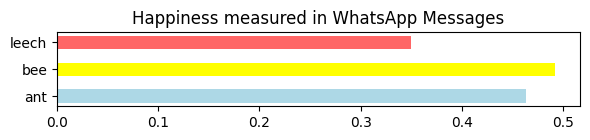

In [ ]:
# Assuming you have a DataFrame called 'df' with columns 'groupflow' and 'column'
column = 'EMOTIONS_Happy'

# Calculate the average value of the specified column for each category
avg_values = df.groupby('groupflow')[column].mean()

# Get unique categories in 'groupflow' column
categories = df['groupflow'].unique()

# Define colors for each category
colors = ['lightblue', 'yellow', (1, 0.4, 0.4)]  # Add more colors if needed

# Specify the order of categories
category_order = ['ant', 'bee', 'leech']

# Set up the figure and axes with adjusted size
fig, ax = plt.subplots(figsize=(6, 1.5))

# Set the width of the bars
bar_width = 0.5

# Plot the average value for each category as a horizontal bar chart
ax.barh(category_order, avg_values[category_order], color=[colors[category_order.index(cat)] for cat in category_order], height=bar_width)

# Set labels and title
ax.set_title('Happiness measured in WhatsApp Messages')

# Adjust the layout to accommodate the horizontal bars and reduce vertical space
plt.tight_layout()

# Display the plot
plt.show()


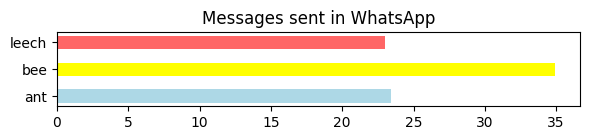

In [ ]:


# Assuming you have a DataFrame called 'df' with columns 'groupflow' and 'column'
column = 'messages_sent'

# Calculate the average value of the specified column for each category
avg_values = df.groupby('groupflow')[column].mean()

# Get unique categories in 'groupflow' column
categories = df['groupflow'].unique()

# Define colors for each category
colors = ['lightblue', 'yellow', (1, 0.4, 0.4)]  # Add more colors if needed

# Specify the order of categories
category_order = ['ant', 'bee', 'leech']

# Set up the figure and axes with adjusted size
fig, ax = plt.subplots(figsize=(6, 1.5))

# Set the width of the bars
bar_width = 0.5

# Plot the average value for each category as a horizontal bar chart
ax.barh(category_order, avg_values[category_order], color=[colors[category_order.index(cat)] for cat in category_order], height=bar_width)

# Set labels and title
ax.set_title('Messages sent in WhatsApp')

# Adjust the layout to accommodate the horizontal bars and reduce vertical space
plt.tight_layout()

# Display the plot
plt.show()

In [ ]:
from sklearn.preprocessing import MinMaxScaler

# Assuming you have a DataFrame called 'df' with a column 'C'

# Create a MinMaxScaler object
scaler = MinMaxScaler()

# Perform min-max scaling on the 'C' column
df['C'] = scaler.fit_transform(df[['C']])

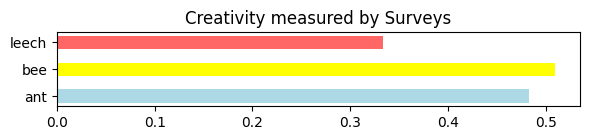

In [ ]:
# Assuming you have a DataFrame called 'df' with columns 'groupflow' and 'column'
column = 'C'

# Calculate the average value of the specified column for each category
avg_values = df.groupby('groupflow')[column].mean()

# Get unique categories in 'groupflow' column
categories = df['groupflow'].unique()

# Define colors for each category
colors = ['lightblue', 'yellow', (1, 0.4, 0.4)]  # Add more colors if needed

# Specify the order of categories
category_order = ['ant', 'bee', 'leech']

# Set up the figure and axes with adjusted size
fig, ax = plt.subplots(figsize=(6, 1.5))

# Set the width of the bars
bar_width = 0.5

# Plot the average value for each category as a horizontal bar chart
ax.barh(category_order, avg_values[category_order], color=[colors[category_order.index(cat)] for cat in category_order], height=bar_width)

# Set labels and title
ax.set_title('Creativity measured by Surveys')

# Adjust the layout to accommodate the horizontal bars and reduce vertical space
plt.tight_layout()

# Display the plot
plt.show()


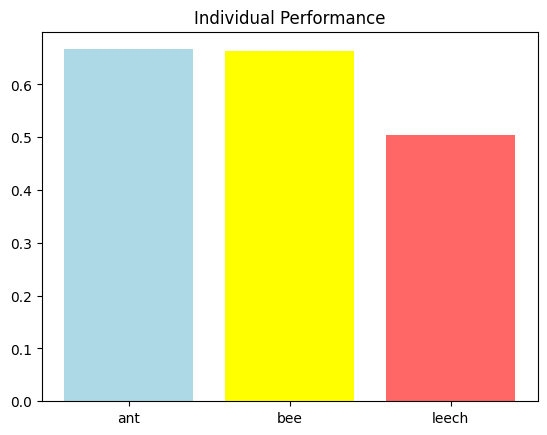

In [ ]:
column='theory'

# Calculate the average value of the specified column for each category
avg_values = df.groupby('groupflow')[column].mean()

# Get unique categories in 'groupflow' column
categories = df['groupflow'].unique()

# Define colors for each category
colors = ['lightblue','yellow', (1, 0.4, 0.4)]  # Add more colors if needed

# Specify the order of categories
category_order = ['ant', 'bee', 'leech']

# Plot the average value for each category as a histogram
plt.bar(category_order, avg_values[category_order], color=[colors[category_order.index(cat)] for cat in category_order])

# Set labels and title
plt.title('Individual Performance')

# Display the plot
plt.show()

In [ ]:
#df= min_max_scaling_df(df,['average_turn_duration', 'num_turns', 'speech_hap', 'messages_sent', 'contribution_index', 'sentiment_avg', 'EMOTIONS_Happy', 'C', 'theory'])
#df['EMOTIONS_Happy'] = df['EMOTIONS_Happy'] * 100

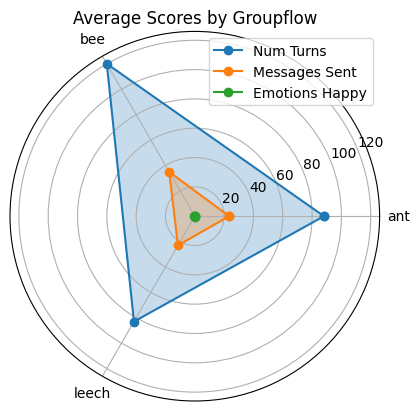

In [ ]:
from math import pi

categories = ['ant', 'bee', 'leech']

num_turns = df.groupby('groupflow')['num_turns'].mean().values.tolist()
num_turns += num_turns[:1]

messages_sent = df.groupby('groupflow')['messages_sent'].mean().values.tolist()
messages_sent += messages_sent[:1]

emotions_happy = df.groupby('groupflow')['EMOTIONS_Happy'].mean().values.tolist()
emotions_happy += emotions_happy[:1]

angles = [n / float(len(categories)) * 2 * pi for n in range(len(categories))]
angles += angles[:1]

plt.polar(angles, num_turns, marker='o', label='Num Turns')
plt.fill(angles, num_turns, alpha=0.25)

plt.polar(angles, messages_sent, marker='o', label='Messages Sent')
plt.fill(angles, messages_sent, alpha=0.25)

plt.polar(angles, emotions_happy, marker='o', label='Emotions Happy')
plt.fill(angles, emotions_happy, alpha=0.25)

plt.xticks(angles[:-1], categories)
plt.title('Average Scores by Groupflow')
plt.legend()
plt.show()


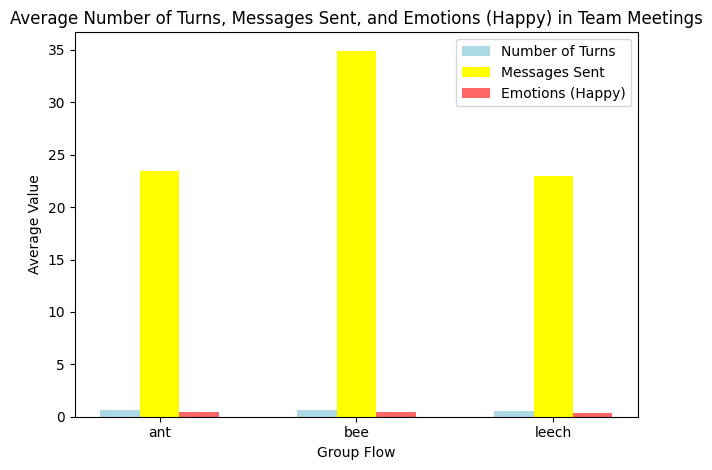

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming you have a DataFrame called 'df' with columns 'groupflow', 'messages_sent', and 'EMOTIONS_Happy'

# Calculate the average value of 'messages_sent' for each category
avg_messages_sent = df.groupby('groupflow')['messages_sent'].mean()

# Calculate the average value of 'EMOTIONS_Happy' for each category
avg_emotions_happy = df.groupby('groupflow')['EMOTIONS_Happy'].mean()

# Get unique categories in 'groupflow' column
categories = df['groupflow'].unique()

# Define colors for each histogram
colors = ['lightblue', 'yellow', (1, 0.4, 0.4)]  # Add more colors if needed

# Specify the order of categories
category_order = ['ant', 'bee', 'leech']

# Set up the figure and axes
fig, ax = plt.subplots()

# Set the width of each bar
bar_width = 0.2

# Set the positions of the bars for each histogram
positions = np.arange(len(category_order))

# Plot the histograms
ax.bar(positions - bar_width, avg_values[category_order], width=bar_width, color=colors[0], label='Number of Turns')
ax.bar(positions, avg_messages_sent[category_order], width=bar_width, color=colors[1], label='Messages Sent')
ax.bar(positions + bar_width, avg_emotions_happy[category_order], width=bar_width, color=colors[2], label='Emotions (Happy)')

# Set x-axis ticks and labels
ax.set_xticks(positions)
ax.set_xticklabels(category_order)

# Set labels and title
ax.set_title('Average Number of Turns, Messages Sent, and Emotions (Happy) in Team Meetings')
ax.set_xlabel('Group Flow')
ax.set_ylabel('Average Value')

# Display the legend
ax.legend()

# Adjust the layout to avoid overlapping of labels
plt.tight_layout()

# Display the plot
plt.show()


In [ ]:
df.head()

,indiv_spoken_time,indiv_spoken_time_ratio,average_turn_duration,average_turn_duration_ratio,avg_time_without_speaking,max_time_without_speaking,num_turns,num_turns_ratio,avg_turns_without_speaking,max_turns_without_speaking,num_words,num_words_ratio,avg_words_turn,speech_neu,speech_ang,speech_hap,speech_sad,text_joy,text_anger,text_fear,text_sadness,group,messages_sent,contribution_index,ego_art,ego_nudges,sentiment_avg,emotionality_avg,influence_message_avg,influence_total_in,influence_message_avg_in,influence_total,contribution_index_oscillation,activity_entanglement,ALTERNATIVE_REALITIES_Treehugger,ALTERNATIVE_REALITIES_Fatherlander,ALTERNATIVE_REALITIES_Spiritualism,ALTERNATIVE_REALITIES_Nerd,EMOTIONS_Fear,EMOTIONS_Happy,EMOTIONS_Sad,EMOTIONS_Anger,Groupflow_Beeflow,Groupflow_Leechflow,Groupflow_Antflow,ethical_likelihood,financial_likelihood,health_likelihood,recreational_likelihood,social_likelihood,total_likelihood,ethical_perceived,financial_perceived,health_perceived,recreational_perceived,social_perceived,total_perceived,O,C,E,A,N,harm_care_score,fairness_reciprocity_score,in_group_loyality_score,authority_respect_score,purity_sanctity_score,theory,groupflow
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,526,0.148336,7.850746,0.126865,56.210746,451.54,67,0.331683,1.985075,7,978,0.170800,14.597015,0.832695,0.137502,0.026347,0.003456,0.298809,0.236814,0.232361,0.232015,1,34,-0.64,1.332,2.468,0.303561,0.215562,0.346,1.227,0.346,1.730,1,0.487649,0.472084,0.083889,0.089140,0.354886,0.236101,0.407447,0.251288,0.105165,0.497477,0.156358,0.346165,4.500000,3.500000,4.166667,3.166667,3.500000,3.766667,4.833333,5.666667,5.666667,5.833333,4.833333,5,0.600000,0.600000,0.600000,0.633333,0.583333,27,23,19,18,20,0.573333,bee
2,2648,0.746757,33.948718,0.548598,21.791169,109.24,78,0.386139,1.589744,9,3816,0.666434,48.923077,0.795958,0.155654,0.045315,0.003074,0.292950,0.239695,0.227768,0.239587,1,75,-0.34,7.778,1.363,0.250396,0.236507,0.428,0.997,0.231,1.988,2,0.398994,0.438515,0.040232,0.107725,0.413528,0.215535,0.417419,0.208064,0.158982,0.300955,0.220056,0.478989,2.000000,1.500000,1.000000,5.166667,5.500000,3.033333,4.000000,6.666667,6.500000,5.500000,3.000000,5,0.533333,0.400000,0.700000,0.616667,0.633333,22,28,11,7,11,0.606667,ant
3,105,0.029611,8.076923,0.130520,57.649231,141.72,13,0.064356,6.461538,15,267,0.046629,20.538462,0.789103,0.161515,0.037497,0.011885,0.297727,0.238513,0.230916,0.232844,1,38,-0.60,1.006,2.010,0.381860,0.254014,0.236,0.866,0.199,103.800,2,0.501416,0.157377,0.028980,0.053947,0.759697,0.245048,0.410218,0.190879,0.153855,0.226931,0.238211,0.534858,4.500000,3.500000,2.666667,6.000000,6.000000,4.533333,5.000000,5.500000,5.500000,4.333333,2.833333,5,0.566667,0.466667,0.716667,0.533333,0.716667,23,28,9,6,7,0.663333,ant
4,162,0.045685,6.480000,0.104714,159.421600,836.46,25,0.123762,6.600000,29,394,0.068809,15.760000,0.712697,0.196289,0.077861,0.013153,0.300100,0.235307,0.232877,0.231716,1,27,-0.70,1.197,2.333,0.250852,0.259828,0.486,2.016,0.467,1.159,2,0.493443,0.258578,0.073231,0.112001,0.556190,0.319698,0.322770,0.225624,0.131909,0.256794,0.232465,0.510740,2.166667,1.500000,1.000000,4.166667,4.833333,2.733333,5.833333,6.000000,6.333333,5.000000,4.166667,5,0.566667,0.866667,0.733333,0.733333,0.633333,17,24,17,13,8,0.703333,ant
5,105,0.029611,5.526316,0.089303,43.632632,169.20,19,0.094059,4.526316,17,271,0.047328,14.263158,0.746439,0.193365,0.054215,0.005981,0.303593,0.235377,0.233832,0.227198,1,22,-0.75,8.437,2.777,0.305600,0.244289,0.360,178.000,0.421,0.970,1,0.555323,0.362543,0.000314,0.136496,0.500648,0.157227,0.472688,0.321906,0.048179,0.342162,0.120088,0.537751,3.166667,2.666667,3.500000,5.166667,3.666667,3.633333,3.666667,5.833333,3.666667,3.000000,3.666667,4,0.600000,0.400000,0.483333,0.583333,0.433333,12,15,11,19,4,0.623333,ant


## Group Analysis

In [ ]:
group_dict = df.groupby('group')['Groupflow_Beeflow'].mean().to_dict()

# Group the DataFrame by 'group' and calculate the mean of 'theory'
group_means = df.groupby('group')['theory'].mean()
indiv_dict = group_means.to_dict()

In [ ]:
dfg.head(15)

,turns_in_a_min,stdev_indiv_spoken_time_ratio,stdev_average_turn_duration,min_average_turn_duration,max_average_turn_duration,stdev_average_turn_duration_ratio,min_average_turn_duration_ratio,max_average_turn_duration_ratio,avg_avg_time_without_speaking,stdev_avg_time_without_speaking,min_avg_time_without_speaking,max_avg_time_without_speaking,stdev_avg_time_without_speaking_ratio,min_avg_time_without_speaking_ratio,max_avg_time_without_speaking_ratio,avg_max_time_without_speaking,stdev_max_time_without_speaking,min_max_time_without_speaking,max_max_time_without_speaking,avg_max_time_without_speaking_ratio,stdev_max_time_without_speaking_ratio,min_max_time_without_speaking_ratio,max_max_time_without_speaking_ratio,avg_num_turns,stdev_num_turns,min_num_turns,max_num_turns,avg_num_turns_ratio,stdev_num_turns_ratio,min_num_turns_ratio,max_num_turns_ratio,avg_avg_turns_without_speaking,stdev_avg_turns_without_speaking,min_avg_turns_without_speaking,max_avg_turns_without_speaking,avg_avg_turns_without_speaking_ratio,stdev_avg_turns_without_speaking_ratio,min_avg_turns_without_speaking_ratio,max_avg_turns_without_speaking_ratio,avg_max_turns_without_speaking,stdev_max_turns_without_speaking,min_max_turns_without_speaking,max_max_turns_without_speaking,avg_max_turns_without_speaking_ratio,stdev_max_turns_without_speaking_ratio,min_max_turns_without_speaking_ratio,max_max_turns_without_speaking_ratio,avg_num_words,stdev_num_words,min_num_words,max_num_words,avg_num_words_ratio,stdev_num_words_ratio,min_num_words_ratio,max_num_words_ratio,avg_avg_words_turn,stdev_avg_words_turn,min_avg_words_turn,max_avg_words_turn,avg_avg_words_turn_ratio,stdev_avg_words_turn_ratio,min_avg_words_turn_ratio,max_avg_words_turn_ratio,avg_max_words_turn,stdev_max_words_turn,min_max_words_turn,max_max_words_turn,avg_max_words_turn_ratio,stdev_max_words_turn_ratio,min_max_words_turn_ratio,max_max_words_turn_ratio,messages_sent_mean,messages_sent_std,messages_total_mean,messages_total_std,contribution_index_mean,contribution_index_std,sentiment_avg_mean,sentiment_avg_std,emotionality_avg_mean,emotionality_avg_std,influence_message_avg_mean,influence_message_avg_std,influence_total_in_mean,influence_message_avg_in_mean,influence_message_avg_in_std,influence_total_mean,contribution_index_oscillation_mean,contribution_index_oscillation_std,activity_entanglement_mean,activity_entanglement_std,ALTERNATIVE_REALITIES_Treehugger_mean,ALTERNATIVE_REALITIES_Treehugger_std,ALTERNATIVE_REALITIES_Fatherlander_mean,ALTERNATIVE_REALITIES_Fatherlander_std,ALTERNATIVE_REALITIES_Spiritualism_mean,ALTERNATIVE_REALITIES_Spiritualism_std,ALTERNATIVE_REALITIES_Nerd_mean,ALTERNATIVE_REALITIES_Nerd_std,EMOTIONS_Fear_mean,EMOTIONS_Fear_std,EMOTIONS_Happy_mean,EMOTIONS_Happy_std,EMOTIONS_Sad_mean,EMOTIONS_Sad_std,EMOTIONS_Anger_mean,EMOTIONS_Anger_std,Groupflow_Beeflow_mean,Groupflow_Beeflow_std,Groupflow_Leechflow_mean,Groupflow_Leechflow_std,Groupflow_Antflow_mean,Groupflow_Antflow_std,ethical_likelihood_mean,ethical_likelihood_std,financial_likelihood_mean,financial_likelihood_std,health_likelihood_mean,health_likelihood_std,recreational_likelihood_mean,recreational_likelihood_std,social_likelihood_mean,social_likelihood_std,total_likelihood_mean,total_likelihood_std,ethical_perceived_mean,ethical_perceived_std,financial_perceived_mean,financial_perceived_std,health_perceived_mean,health_perceived_std,recreational_perceived_mean,recreational_perceived_std,social_perceived_mean,social_perceived_std,total_perceived_mean,total_perceived_std,O_mean,O_std,C_mean,C_std,E_mean,E_std,A_mean,A_std,N_mean,N_std,harm_care_score_mean,harm_care_score_std,fairness_reciprocity_score_mean,fairness_reciprocity_score_std,in_group_loyality_score_mean,in_group_loyality_score_std,authority_respect_score_mean,authority_respect_score_std,purity_sanctity_score_mean,purity_sanctity_score_std,dummy_question1_mean,dummy_question1_std,dummy_question2_mean,dummy_question2_std,q1_mean,q1_std,q2_mean,q2_std,q3_

In [ ]:
import pandas as pd

# Assuming you have a dataframe called 'df'
pattern_starts_with = '^diff'
columns_to_drop_starts_with = dfg.filter(regex=pattern_starts_with).columns
print(columns_to_drop_starts_with)

# Drop the columns that start with 'diff'
dfg = dfg.drop(columns=columns_to_drop_starts_with)

# Assuming you have a dataframe called 'df'
pattern_ends_with = 'difference$'
columns_to_drop_ends_with = dfg.filter(regex=pattern_ends_with).columns
print(columns_to_drop_ends_with)

# Drop the columns that end with 'difference'
dfg = dfg.drop(columns=columns_to_drop_ends_with)

dfg = dfg.drop(columns='min_theory')



Index([], dtype='object')
Index([], dtype='object')


In [ ]:
dfg.columns

Index(['turns_in_a_min', 'stdev_indiv_spoken_time_ratio',
       'stdev_average_turn_duration', 'min_average_turn_duration',
       'max_average_turn_duration', 'stdev_average_turn_duration_ratio',
       'min_average_turn_duration_ratio', 'max_average_turn_duration_ratio',
       'avg_avg_time_without_speaking', 'stdev_avg_time_without_speaking',
       ...
       'q10_mean', 'q10_std', 'conservation_mean', 'conservation_std',
       'transcendence_mean', 'transcendence_std', 'mean_theory', 'max_theory',
       'min_theory', 'final_project'],
      dtype='object', length=189)

In [ ]:
dfg.head(15)

,turns_in_a_min,stdev_indiv_spoken_time_ratio,stdev_average_turn_duration,min_average_turn_duration,max_average_turn_duration,stdev_average_turn_duration_ratio,min_average_turn_duration_ratio,max_average_turn_duration_ratio,avg_avg_time_without_speaking,stdev_avg_time_without_speaking,min_avg_time_without_speaking,max_avg_time_without_speaking,stdev_avg_time_without_speaking_ratio,min_avg_time_without_speaking_ratio,max_avg_time_without_speaking_ratio,avg_max_time_without_speaking,stdev_max_time_without_speaking,min_max_time_without_speaking,max_max_time_without_speaking,avg_max_time_without_speaking_ratio,stdev_max_time_without_speaking_ratio,min_max_time_without_speaking_ratio,max_max_time_without_speaking_ratio,avg_num_turns,stdev_num_turns,min_num_turns,max_num_turns,avg_num_turns_ratio,stdev_num_turns_ratio,min_num_turns_ratio,max_num_turns_ratio,avg_avg_turns_without_speaking,stdev_avg_turns_without_speaking,min_avg_turns_without_speaking,max_avg_turns_without_speaking,avg_avg_turns_without_speaking_ratio,stdev_avg_turns_without_speaking_ratio,min_avg_turns_without_speaking_ratio,max_avg_turns_without_speaking_ratio,avg_max_turns_without_speaking,stdev_max_turns_without_speaking,min_max_turns_without_speaking,max_max_turns_without_speaking,avg_max_turns_without_speaking_ratio,stdev_max_turns_without_speaking_ratio,min_max_turns_without_speaking_ratio,max_max_turns_without_speaking_ratio,avg_num_words,stdev_num_words,min_num_words,max_num_words,avg_num_words_ratio,stdev_num_words_ratio,min_num_words_ratio,max_num_words_ratio,avg_avg_words_turn,stdev_avg_words_turn,min_avg_words_turn,max_avg_words_turn,avg_avg_words_turn_ratio,stdev_avg_words_turn_ratio,min_avg_words_turn_ratio,max_avg_words_turn_ratio,avg_max_words_turn,stdev_max_words_turn,min_max_words_turn,max_max_words_turn,avg_max_words_turn_ratio,stdev_max_words_turn_ratio,min_max_words_turn_ratio,max_max_words_turn_ratio,messages_sent_mean,messages_sent_std,messages_total_mean,messages_total_std,contribution_index_mean,contribution_index_std,sentiment_avg_mean,sentiment_avg_std,emotionality_avg_mean,emotionality_avg_std,influence_message_avg_mean,influence_message_avg_std,influence_total_in_mean,influence_message_avg_in_mean,influence_message_avg_in_std,influence_total_mean,contribution_index_oscillation_mean,contribution_index_oscillation_std,activity_entanglement_mean,activity_entanglement_std,ALTERNATIVE_REALITIES_Treehugger_mean,ALTERNATIVE_REALITIES_Treehugger_std,ALTERNATIVE_REALITIES_Fatherlander_mean,ALTERNATIVE_REALITIES_Fatherlander_std,ALTERNATIVE_REALITIES_Spiritualism_mean,ALTERNATIVE_REALITIES_Spiritualism_std,ALTERNATIVE_REALITIES_Nerd_mean,ALTERNATIVE_REALITIES_Nerd_std,EMOTIONS_Fear_mean,EMOTIONS_Fear_std,EMOTIONS_Happy_mean,EMOTIONS_Happy_std,EMOTIONS_Sad_mean,EMOTIONS_Sad_std,EMOTIONS_Anger_mean,EMOTIONS_Anger_std,Groupflow_Beeflow_mean,Groupflow_Beeflow_std,Groupflow_Leechflow_mean,Groupflow_Leechflow_std,Groupflow_Antflow_mean,Groupflow_Antflow_std,ethical_likelihood_mean,ethical_likelihood_std,financial_likelihood_mean,financial_likelihood_std,health_likelihood_mean,health_likelihood_std,recreational_likelihood_mean,recreational_likelihood_std,social_likelihood_mean,social_likelihood_std,total_likelihood_mean,total_likelihood_std,ethical_perceived_mean,ethical_perceived_std,financial_perceived_mean,financial_perceived_std,health_perceived_mean,health_perceived_std,recreational_perceived_mean,recreational_perceived_std,social_perceived_mean,social_perceived_std,total_perceived_mean,total_perceived_std,O_mean,O_std,C_mean,C_std,E_mean,E_std,A_mean,A_std,N_mean,N_std,harm_care_score_mean,harm_care_score_std,fairness_reciprocity_score_mean,fairness_reciprocity_score_std,in_group_loyality_score_mean,in_group_loyality_score_std,authority_respect_score_mean,authority_respect_score_std,purity_sanctity_score_mean,purity_sanctity_score_std,dummy_question1_mean,dummy_question1_std,dummy_question2_mean,dummy_question2_std,q1_mean,q1_std,q2_mean,q2_std,q3_

In [ ]:
filename = "group_features_%bee.xlsx"

# Save the DataFrame to Excel
dfg.to_excel(filename, index=True)

In [ ]:
stop

NameError: ignored

In [ ]:
# Create a new column 'bee_percentage' using the dictionary values
dfg['bee_percentage'] = dfg.index.map(group_dict)
dfg['indiv_mean_perf'] = dfg.index.map(indiv_dict)

dfg['has_bee'] = dfg['bee_percentage'] > 0.25

In [ ]:
# Group the DataFrame by 'mark' and calculate the average of other columns
grouped_df = dfg.groupby('has_bee').mean()

grouped_df.head()

In [ ]:
# stdev_indiv_spoken_time_ratio , sentiment_avg_mean , EMOTIONS_Happy_mean

In [ ]:
from scipy import stats

def perform_ttest_by_category(df, column):
    category1 = df[df[column] == True]
    category2 = df[df[column] == False]
    t_test_features=[]

    for feature in df.columns:
        if feature != column:

            t_value, p_value = stats.ttest_ind(category1[feature], category2[feature])
            if(p_value<0.05):
              t_test_features.append(feature)
              print(f"Feature: {feature}")
              print(f"T-value: {t_value}")
              print(f"P-value: {p_value}")
              print("---")

    return t_test_features

In [ ]:
# Assuming you have a dataframe called 'my_dataframe' with a column 'group_column'
t_test_features= perform_ttest_by_category(dfg, 'has_bee')


In [ ]:
print(grouped_df[t_test_features])

In [ ]:
# Group the DataFrame by 'has_bee' column and calculate the average of 'final_project'
avg_final_project = dfg.groupby('has_bee')['final_project'].mean()

# Define custom colors for the bars
colors = ['lightblue', 'yellow']

# Define custom labels for the bars
labels = ['Teams Without Bees', 'Teams With Bees']

# Plot the histogram with custom colors and labels
plt.bar(labels, avg_final_project, color=colors)

# Set labels and title
#plt.title('Average Grade Group Project')

# Add custom text labels on top of each bar
for i, value in enumerate(avg_final_project):
    plt.text(i, value, f'{value:.2f}', ha='center', va='bottom')

# Set the y-axis limit until 1
plt.ylim(0, 1)

# Display the plot
plt.show()




In [ ]:
import matplotlib.pyplot as plt

# Assuming your DataFrame is named 'dfg'

# Create a scatter plot with larger dots
plt.scatter(dfg['indiv_mean_perf'], dfg['final_project'], s=75, c=dfg['has_bee'].map({True: 'yellow', False: 'lightblue'}))

# Set labels and title
plt.xlabel('Individual Average Score')
plt.ylabel('Group Project Grade')
plt.title('Importance of Having Bees in the Team')

# Create a legend with explanations
legend_elements = [
    plt.scatter([], [], color='yellow', label='Yes'),
    plt.scatter([], [], color='lightblue', label='No')
]
plt.legend(handles=legend_elements, loc='lower right', title='¿Bees in Team?')

# Display the plot
plt.show()
